In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr
import warnings
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import gridspec
import datetime
import seaborn as sns
import cmocean as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.stats import linregress
import matplotlib.patches as mpatches
import scipy.io as sio
import matplotlib.colors as mcolors
import matplotlib.patches as patch
import sys
import os
sys.path.append(os.path.abspath('../scripts'))
from proj_utils import *
fig_path      = '../figures'

In [2]:
s3, credentials = init_S3FileSystem(use_earthdata=False, requester_pays=True)
mzz_local_directory = Path('/efs_ecco/mzz-jsons-V4r5/MZZ_mon_mean_native')

In [3]:
mzz_local_file= mzz_local_directory / 'OCEAN_VELOCITY_mon_mean_native_llc090_ECCOV4r5.json' # Pull monthly velocity 
fs = fsspec.filesystem("reference",     
                       fo=str(mzz_local_file),
                       remote_protocol="s3",
                       remote_options={"anon":False, "requester_pays":True},
                       skip_instance_cache=True)
# 
fs.asynchronous = True
store = zarr.storage.FsspecStore(fs)
ds = xr.open_dataset(store, engine='zarr',
                     consolidated=False, chunks={'time':4, 'Z':50})

In [4]:
bathy_path = user_home_dir + '/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc'
ds_bathy   = xr.open_dataset(bathy_path).Depth
ds_geom    = xr.open_dataset(bathy_path)

In [5]:
ds = get_na_tile(ds)
ds = subset_tgb_box(ds)
ds_east_face = ds.sel(j = slice(ds.j[0]-0.25,ds.j[0]+0.25), j_g = slice(ds.j_g[0]-0.25,ds.j_g[0]+0.25)).squeeze()

In [6]:
v    = ds_east_face['VVEL'].squeeze()
hfac = ds_geom_east['hFacS'].squeeze()
dx   = ds_geom_east['dxC'].squeeze()
drf  = ds_geom_east['drF'].squeeze()

In [7]:
drf_3d = drf.broadcast_like(v)
dx_3d  = dx.broadcast_like(v)

In [8]:
area = dx_3d * drf_3d * hfac
flux_east = (v * area).sel(i_g = 42)

In [9]:
flux_east = flux_east.load()

In [10]:
flux_east_mn = flux_east.mean(dim = 'time')

/tmp/ipykernel_2803/420833843.py:7: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar()


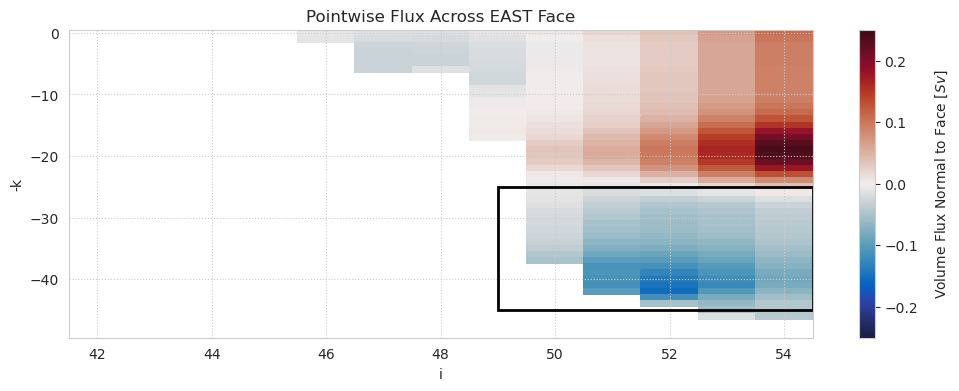

In [11]:
sv_name = '/point_wise_mn_east_flux'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=[12,4])
levels = np.linspace(-0.15,0.50,41)

plt.pcolor(ds_east_face.i,-ds_east_face.k,flux_east_mn/1e6,cmap='cmo.balance',vmin = -0.25, vmax = 0.25, zorder = 0)
cbar = plt.colorbar()
cbar.set_label('Volume Flux Normal to Face [$Sv$]',  labelpad=11)
plt.xlabel('i')
plt.ylabel('-k')
ax.add_patch(patch.Rectangle((49,-45),5.5,20,facecolor='None',edgecolor='k',linewidth=2))
plt.title('Pointwise Flux Across EAST Face')
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)

In [12]:
ds_north_face = ds.sel(i = slice(ds.i[0]), i_g = slice(ds.i_g[0])).squeeze()
ds_geom_north = ds_geom.sel(i = slice(ds.i[0]), i_g = slice(ds.i_g[0])).squeeze()

In [13]:
# --- Flux NORTH FACE ---
u    = ds_north_face['UVEL'].squeeze()
hfac = ds_geom_north['hFacW'].squeeze()
dy   = ds_geom_north['dyC'].squeeze()
drf  = ds_geom_north['drF'].squeeze()

In [14]:
drf_3d = drf.broadcast_like(u)
dx_3d  = dy.broadcast_like(u)

In [15]:
area = dx_3d * drf_3d * hfac

In [16]:
flux_north = (u * area).sel(j_g = 72).squeeze()

In [17]:
flux_north = flux_north.load()

In [18]:
flux_north_mn = flux_north.mean(dim = 'time')

/tmp/ipykernel_2803/646062389.py:8: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar()


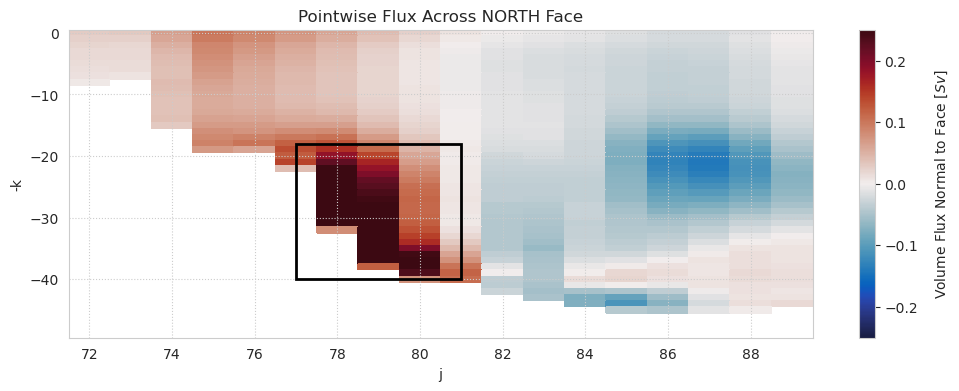

In [19]:
sv_name = '/point_wise_mn_north_flux'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=[12,4])
levels = np.linspace(-0.15,0.50,41)

plt.pcolor(ds_north_face.j,-ds_north_face.k,flux_north_mn/1e6,cmap='cmo.balance',vmin = -0.25, vmax = 0.25,zorder = 0)
plt.title('Pointwise Flux Across NORTH Face')
cbar = plt.colorbar()
cbar.set_label('Volume Flux Normal to Face [$Sv$]',  labelpad=11)
plt.xlabel('j')
plt.ylabel('-k')
ax.add_patch(patch.Rectangle((77,-40),4,22,facecolor='None',edgecolor='k',linewidth=2))
#plt.ylim([-25, 0])
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)

In [20]:
ds_west_face = ds.sel(j = slice(ds.j[-1]-0.25,ds.j[-1]+0.25), j_g = slice(ds.j_g[-1]-0.25,ds.j_g[-1]+0.25)).squeeze()
ds_geom_west= ds_geom.sel(j = slice(ds.j[-1]-0.25,ds.j[-1]+0.25), j_g = slice(ds.j_g[-1]-0.25,ds.j_g[-1]+0.25)).squeeze()

In [21]:
v    = ds_west_face['VVEL'].squeeze()
hfac = ds_geom_west['hFacS'].squeeze()
dx   = ds_geom_west['dxC'].squeeze()
drf  = ds_geom_west['drF'].squeeze()

In [22]:
drf_3d = drf.broadcast_like(v)
dx_3d  = dy.broadcast_like(v)

In [23]:
area = dx_3d * drf_3d * hfac

In [24]:
flux_west = (v * area)

In [25]:
flux_west_mn = flux_west.mean(dim = 'time').sel(j_g = 86).squeeze()

In [26]:
v_mn = v.mean(dim = 'time')

/tmp/ipykernel_2803/2952419242.py:7: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar()


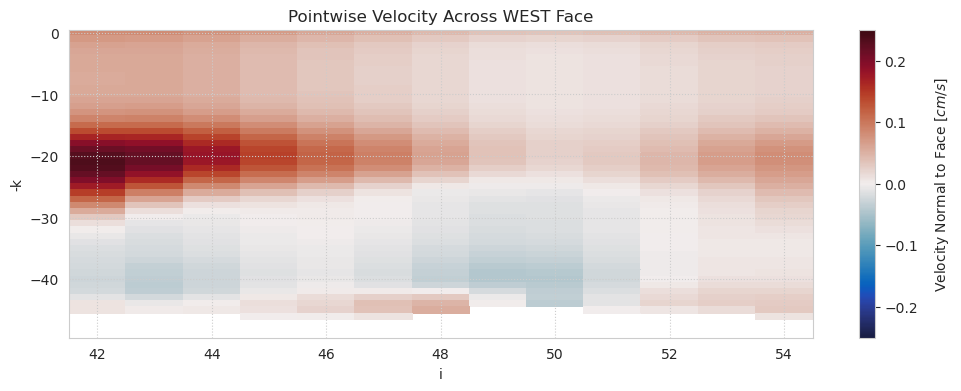

In [27]:
sv_name = '/point_wise_mn_west_flux'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=[12,4])
levels = np.linspace(-0.15,0.50,41)

plt.pcolor(ds_west_face.i,-ds_west_face.k,flux_west_mn/1e6,cmap='cmo.balance',vmin = -0.25, vmax = 0.25,zorder = 0)
cbar = plt.colorbar()
cbar.set_label('Velocity Normal to Face [$cm/s$]',  labelpad=11)
plt.xlabel('i')
plt.ylabel('-k')
#ax.add_patch(patch.Rectangle((49,-45),5.5,20,facecolor='None',edgecolor='k',linewidth=2))
plt.title('Pointwise Velocity Across WEST Face')
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)

In [28]:
ds_south_face = ds.sel(i = slice(ds.i[-1]-0.25,ds.i[-1]+0.25), i_g = slice(ds.i_g[-1]-0.25,ds.i_g[-1]+0.25)).squeeze()
ds_geom_south = ds_geom.sel(i = slice(ds.i[-1]-0.25,ds.i[-1]+0.25), i_g = slice(ds.i_g[-1]-0.25,ds.i_g[-1]+0.25)).squeeze()

In [29]:
# --- Flux NORTH FACE ---
u    = ds_south_face['UVEL'].squeeze()
hfac = ds_geom_south['hFacW'].squeeze()
dy   = ds_geom_south['dyC'].squeeze()
drf  = ds_geom_south['drF'].squeeze()

In [30]:
drf_3d = drf.broadcast_like(u)
dx_3d  = dy.broadcast_like(u)

In [31]:
area = dx_3d * drf_3d * hfac

In [32]:
flux_south =  (u * area.sel(j_g = 72).squeeze())

In [33]:
flux_south = flux_south.load()

In [34]:
flux_south_mn = flux_south.mean(dim = 'time')

/tmp/ipykernel_2803/4097860195.py:8: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = plt.colorbar()


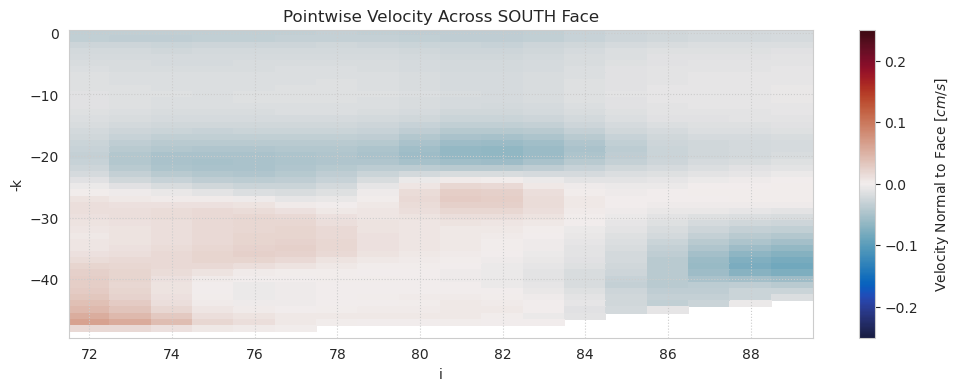

In [35]:
sv_name = '/point_wise_mn_north_flux'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig, ax = plt.subplots(figsize=[12,4])
levels = np.linspace(-0.15,0.50,41)

plt.pcolor(ds_south_face.j,-ds_south_face.k,-flux_south_mn/1e6,cmap='cmo.balance',vmin = -0.25, vmax = 0.25,zorder = 0)
plt.title('Pointwise Velocity Across SOUTH Face')
cbar = plt.colorbar()
cbar.set_label('Velocity Normal to Face [$cm/s$]',  labelpad=11)
plt.xlabel('i')
plt.ylabel('-k')
#ax.add_patch(patch.Rectangle((77,-40),4,22,facecolor='None',edgecolor='k',linewidth=2))
#plt.ylim([-25, 0])
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)

In [36]:
flux_east_mask = flux_east[:,25:45,7:13]
flux_north_mask = flux_north[:,18:40,5:10]

In [37]:
np.corrcoef(flux_north_mask.sum(dim = ('k','j'))/1e6,-flux_east_mask.sum(dim = ('k','i'))/1e6)[0,1]

np.float64(0.5057953107710546)

Text(0, 0.5, 'Volume Flux of DWBC [$Sv$]')

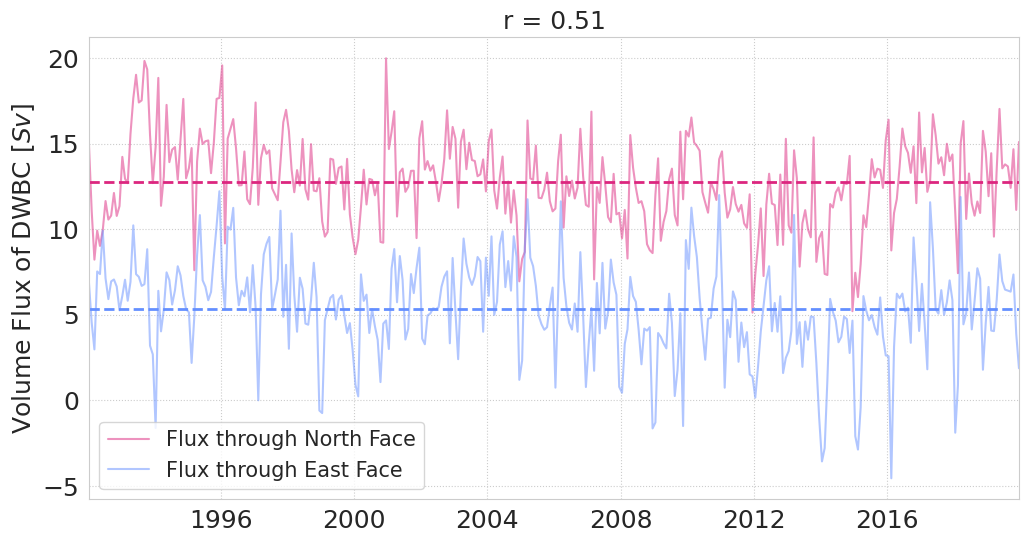

In [38]:
sv_name = '/north_face_east_face_flux_ts'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig     = plt.figure(figsize=(12, 6))

north_face  = plt.plot(flux_north_mask.time,flux_north_mask.sum(dim = ('k','j'))/1e6, c = '#dc267f', alpha = 0.5, label = 'Flux through North Face')
east_face  = plt.plot(flux_east_mask.time,-flux_east_mask.sum(dim = ('k','i'))/1e6, c = '#648fff', alpha = 0.5, label = 'Flux through East Face')

mean_flux   = plt.axhline(flux_north_mask.sum(dim = ('k','j')).mean(dim='time').compute()/1e6, color = '#dc267f', linestyle = '--', linewidth = 2)
mean_flux   = plt.axhline(-flux_east_mask.sum(dim = ('k','i')).mean(dim='time').compute()/1e6, color = '#648fff', linestyle = '--', linewidth = 2)
xtix = plt.yticks(fontsize=18)
xtix = plt.xticks(fontsize=18)

plt.xlim(flux_north.time[0],flux_north.time[-1])
plt.title('r = ' + str('{:.2f}'.format(np.corrcoef(flux_north_mask.sum(dim = ('k','j'))/1e6,-flux_east_mask.sum(dim = ('k','i'))/1e6)[0,1])), fontsize = 18)
plt.legend(fontsize=15)
plt.ylabel('Volume Flux of DWBC [$Sv$]',fontsize = 18 )
#plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)

### Flux North
#plt.plot(flux_north_mask.sum(dim = ('k','j'))/1e6)
#plt.plot(-flux_east_mask.sum(dim = ('k','i'))/1e6)

[]

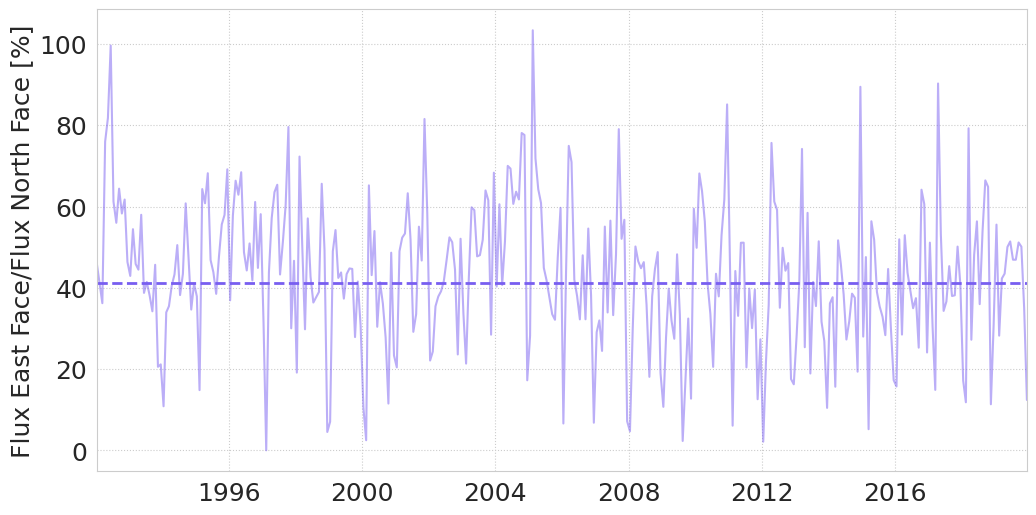

In [44]:
sv_name = '/north_face_east_face_ratio_ts'
sns.set_style('whitegrid',{"grid.linestyle": ":"})
fig     = plt.figure(figsize=(12, 6))

north_face  = plt.plot(flux_east.time, (abs(flux_east_mask.sum(dim = ('k','i')))/abs(flux_north_mask.sum(dim = ('k','j')))*100), alpha = 0.5, c = '#785ef0')

mean_flux   = plt.axhline((-(flux_east_mask.sum(dim = ('k','i'))/1e6)/(flux_north_mask.sum(dim = ('k','j'))/1e6)*100).mean(), color = '#785ef0', linestyle = '--', linewidth = 2)
xtix = plt.yticks(fontsize=18)
xtix = plt.xticks(fontsize=18)

plt.xlim(flux_north.time[0],flux_north.time[-1])
#plt.title('Ratio of Flux Out to Flux In ', fontsize = 18)
plt.ylabel('Flux East Face/Flux North Face [%]',fontsize = 18 )
plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)

plt.plot()

In [40]:
sys.path.append(os.path.abspath('../scripts'))
from proj_utils import *
from analysis_helpers import *
fig_path      = '../figures'

north_freq, psd, north_spectrum = calc_flux_spec((flux_north_mask.sum(dim = ('k','j'))/1e6))
east_freq, psd, east_spectrum  = calc_flux_spec((flux_east_mask.sum(dim = ('k','i'))/1e6))

Text(0, 0.5, 'PSD')

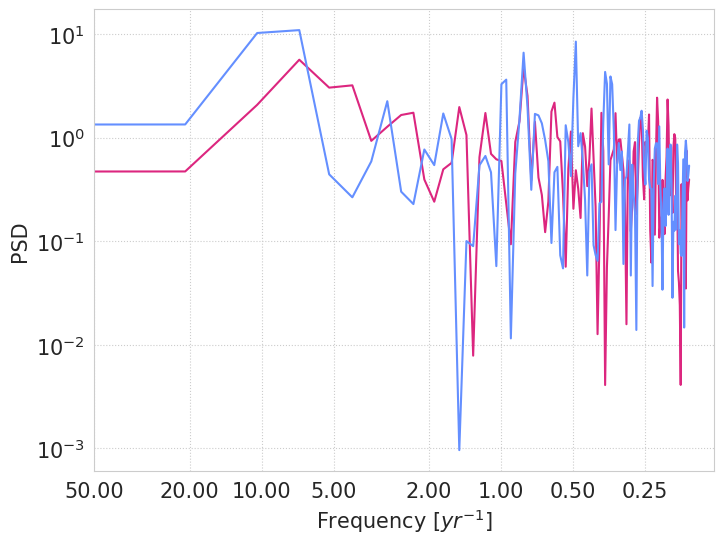

In [43]:
# ---  Spectra of North Face and East Face Fluxes ---
sv_name = '/north_face_east_face_specs'
fig     = plt.figure(figsize=(8, 6))
plt.xscale('log')
plt.yscale('log')
periods = np.array([0.25, 0.5, 1, 2, 5, 10, 20, 50])  # years
frequencies = 1 / periods
frequencies = frequencies[(frequencies >= north_freq.min()) & (frequencies <= north_freq.max())]
period_labels = [f'{1/f:.2f}' for f in frequencies]  # years

plt.plot(north_spectrum.frequency,north_spectrum,c = '#dc267f')
plt.plot(east_spectrum.frequency,east_spectrum,c = '#648fff')

plt.xticks(frequencies, labels=period_labels,fontsize = 15)
plt.yticks(fontsize = 15)



plt.xlabel('Frequency [$yr^{-1}$]',fontsize = 15)
plt.ylabel('PSD',fontsize = 15)
#plt.savefig(fig_path + sv_name + '.png', format='png', bbox_inches="tight",dpi=500)